# Предсказание стоимости жилья

## Описание задачи

- Необходимо обучить 2 модели линейной регрессии на данных о жилье в Калифорнии в 1990 году
    - Первая используя все данные
    - Вторая используя только числовые переменные, исключив категориальные
- На основе данных нужно предсказать медианную стоимость дома в жилом массиве
- Сделать предсказания на тестовой выборке
- Для оценки качества модели использовать метрики RMSE, MAE и R2


- При обработке данных заменить пропущенные значения по своему усмотрению
- Преобразовать колонку с категориальными значениями техникой One-hot encoding

## Описание данных

Предсказывающие признаки:
- `longitude` — широта
- `latitude` — долгота
- `housing_median_age` — медианный возраст жителей жилого массива
- `total_rooms` — общее количество комнат в домах жилого массива
- `total_bedrooms` — общее количество спален в домах жилого массива
- `population` — количество человек, которые проживают в жилом массиве
- `households` — количество домовладений в жилом массиве
- `median_income` — медианный доход жителей жилого массива
- `ocean_proximity` — близость к океану

Целевой признак:
- `median_house_value` — медианная стоимость дома в жилом массиве

## Описание задачи в терминах машинного обучения

Задача регрессии

## Подключение библиотек

In [1]:
import pandas as pd
import seaborn as sns

import pyspark
import pyspark.sql.functions as F

from IPython.display import display, Markdown
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.ml.feature import StringIndexer, OneHotEncoder, StandardScaler, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

In [2]:
# Вспомогательные переменные
RANDOM_SEED = 12345

caption_style = [
    dict(selector="caption",
         props=[("text-align", "center"),
                ("font-weight", "bold"),
                ("font-size", "large"),
                ("color", "black")])]

In [3]:
# Вспомогательные функции
def check_missing_values(df):
    missing_values = []
    for column_name in df.columns:
        missing_values.append([column_name, df.filter(F.col(column_name).isNull()).count()])

    return pd.DataFrame(missing_values, columns=['column_name', 'count']) \
        .style.set_caption('Пропущенные значения').set_table_styles(caption_style).hide_index()

## Получение данных

In [4]:
# Инициализация Spark-сессии
spark = SparkSession \
    .builder \
    .appName('prediction_house_cost') \
    .getOrCreate()

In [5]:
# Задаём правильные типы для данных
custom_schema = StructType([
    StructField("longitude", FloatType(), True),
    StructField("latitude", FloatType(), True),
    StructField("housing_median_age", FloatType(), True),
    StructField("total_rooms", FloatType(), True),
    StructField("total_bedrooms", FloatType(), True),
    StructField("population", FloatType(), True),
    StructField("households", FloatType(), True),
    StructField("median_income", FloatType(), True),
    StructField("median_house_value", FloatType(), True),
    StructField("ocean_proximity", StringType(), True)
])

spark_df = spark \
    .read \
    .option('header', True) \
    .schema(custom_schema) \
    .csv('/datasets/housing.csv')

## Изучение данных

In [6]:
display(Markdown('**Типы данных**'))
spark_df.printSchema()
display(Markdown('**Пример. Первые 20 наблюдений**'))
spark_df.show()
display(Markdown('**Количество наблюдений**'))
spark_df.count()

**Типы данных**

root
 |-- longitude: float (nullable = true)
 |-- latitude: float (nullable = true)
 |-- housing_median_age: float (nullable = true)
 |-- total_rooms: float (nullable = true)
 |-- total_bedrooms: float (nullable = true)
 |-- population: float (nullable = true)
 |-- households: float (nullable = true)
 |-- median_income: float (nullable = true)
 |-- median_house_value: float (nullable = true)
 |-- ocean_proximity: string (nullable = true)



**Пример. Первые 20 наблюдений**

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|       NEAR BAY|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|          352100.0|       NEAR BAY|
|  -122.25|   37.85|              52.0|     1274.0|         235.0|     558.0|     219.0|       5.6431|          341300.0|       NEAR BAY|
|  -122.25|   37.85|              

**Количество наблюдений**

20640

## Предобработка данных

### Пропуски

Проверяем наличие пропусков

In [7]:
check_missing_values(spark_df)

column_name,count
longitude,0
latitude,0
housing_median_age,0
total_rooms,0
total_bedrooms,207
population,0
households,0
median_income,0
median_house_value,0
ocean_proximity,0


Заполняем пропуски медианным значением

In [8]:
median_tb = float(spark_df.select('total_bedrooms').orderBy(F.rand(seed=RANDOM_SEED)).limit(10_000).toPandas().median())
median_tb

433.5

In [9]:
spark_df_clear = spark_df.fillna({'total_bedrooms': median_tb})

Проверяем коррекность удаления пропусков

In [10]:
check_missing_values(spark_df_clear)

column_name,count
longitude,0
latitude,0
housing_median_age,0
total_rooms,0
total_bedrooms,0
population,0
households,0
median_income,0
median_house_value,0
ocean_proximity,0


## Анализ данных

In [11]:
# Получаем случайную часть данных для представления о всех данных
data = spark_df_clear.orderBy(F.rand(seed=RANDOM_SEED)).limit(10_000).toPandas()
data

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-117.709999,33.599998,8.0,3329.0,753.0,1312.0,629.0,3.5521,229800.0,<1H OCEAN
1,-121.970001,37.250000,21.0,2775.0,389.0,856.0,350.0,7.9135,496400.0,<1H OCEAN
2,-117.510002,33.880001,24.0,3044.0,602.0,2541.0,564.0,4.1310,123800.0,INLAND
3,-118.489998,34.259998,25.0,8389.0,1872.0,4483.0,1747.0,3.5497,261300.0,<1H OCEAN
4,-117.059998,32.790001,17.0,2524.0,332.0,771.0,317.0,8.7604,331800.0,<1H OCEAN
...,...,...,...,...,...,...,...,...,...,...
9995,-117.919998,33.770000,28.0,3614.0,960.0,3282.0,889.0,3.5220,190300.0,<1H OCEAN
9996,-117.309998,33.160000,4.0,5846.0,894.0,2282.0,801.0,5.5956,247800.0,NEAR OCEAN
9997,-118.260002,34.240002,35.0,1666.0,280.0,788.0,273.0,6.6277,344400.0,<1H OCEAN
9998,-117.050003,32.570000,22.0,2857.0,516.0,2412.0,496.0,4.7337,127600.0,NEAR OCEAN


Корреляции

In [12]:
data.corr()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.923868,-0.104622,0.025909,0.051793,0.084031,0.041550,-0.006182,-0.032536
latitude,-0.923868,1.000000,0.006616,-0.016165,-0.047306,-0.091193,-0.054716,-0.089983,-0.158020
housing_median_age,-0.104622,0.006616,1.000000,-0.357174,-0.319419,-0.285792,-0.300600,-0.113396,0.101073
total_rooms,0.025909,-0.016165,-0.357174,1.000000,0.929615,0.855169,0.923261,0.197875,0.136109
total_bedrooms,0.051793,-0.047306,-0.319419,0.929615,1.000000,0.873006,0.978069,-0.005446,0.050383
population,0.084031,-0.091193,-0.285792,0.855169,0.873006,1.000000,0.903463,0.004196,-0.022373
households,0.041550,-0.054716,-0.300600,0.923261,0.978069,0.903463,1.000000,0.014811,0.066738
median_income,-0.006182,-0.089983,-0.113396,0.197875,-0.005446,0.004196,0.014811,1.000000,0.692246
median_house_value,-0.032536,-0.158020,0.101073,0.136109,0.050383,-0.022373,0.066738,0.692246,1.000000


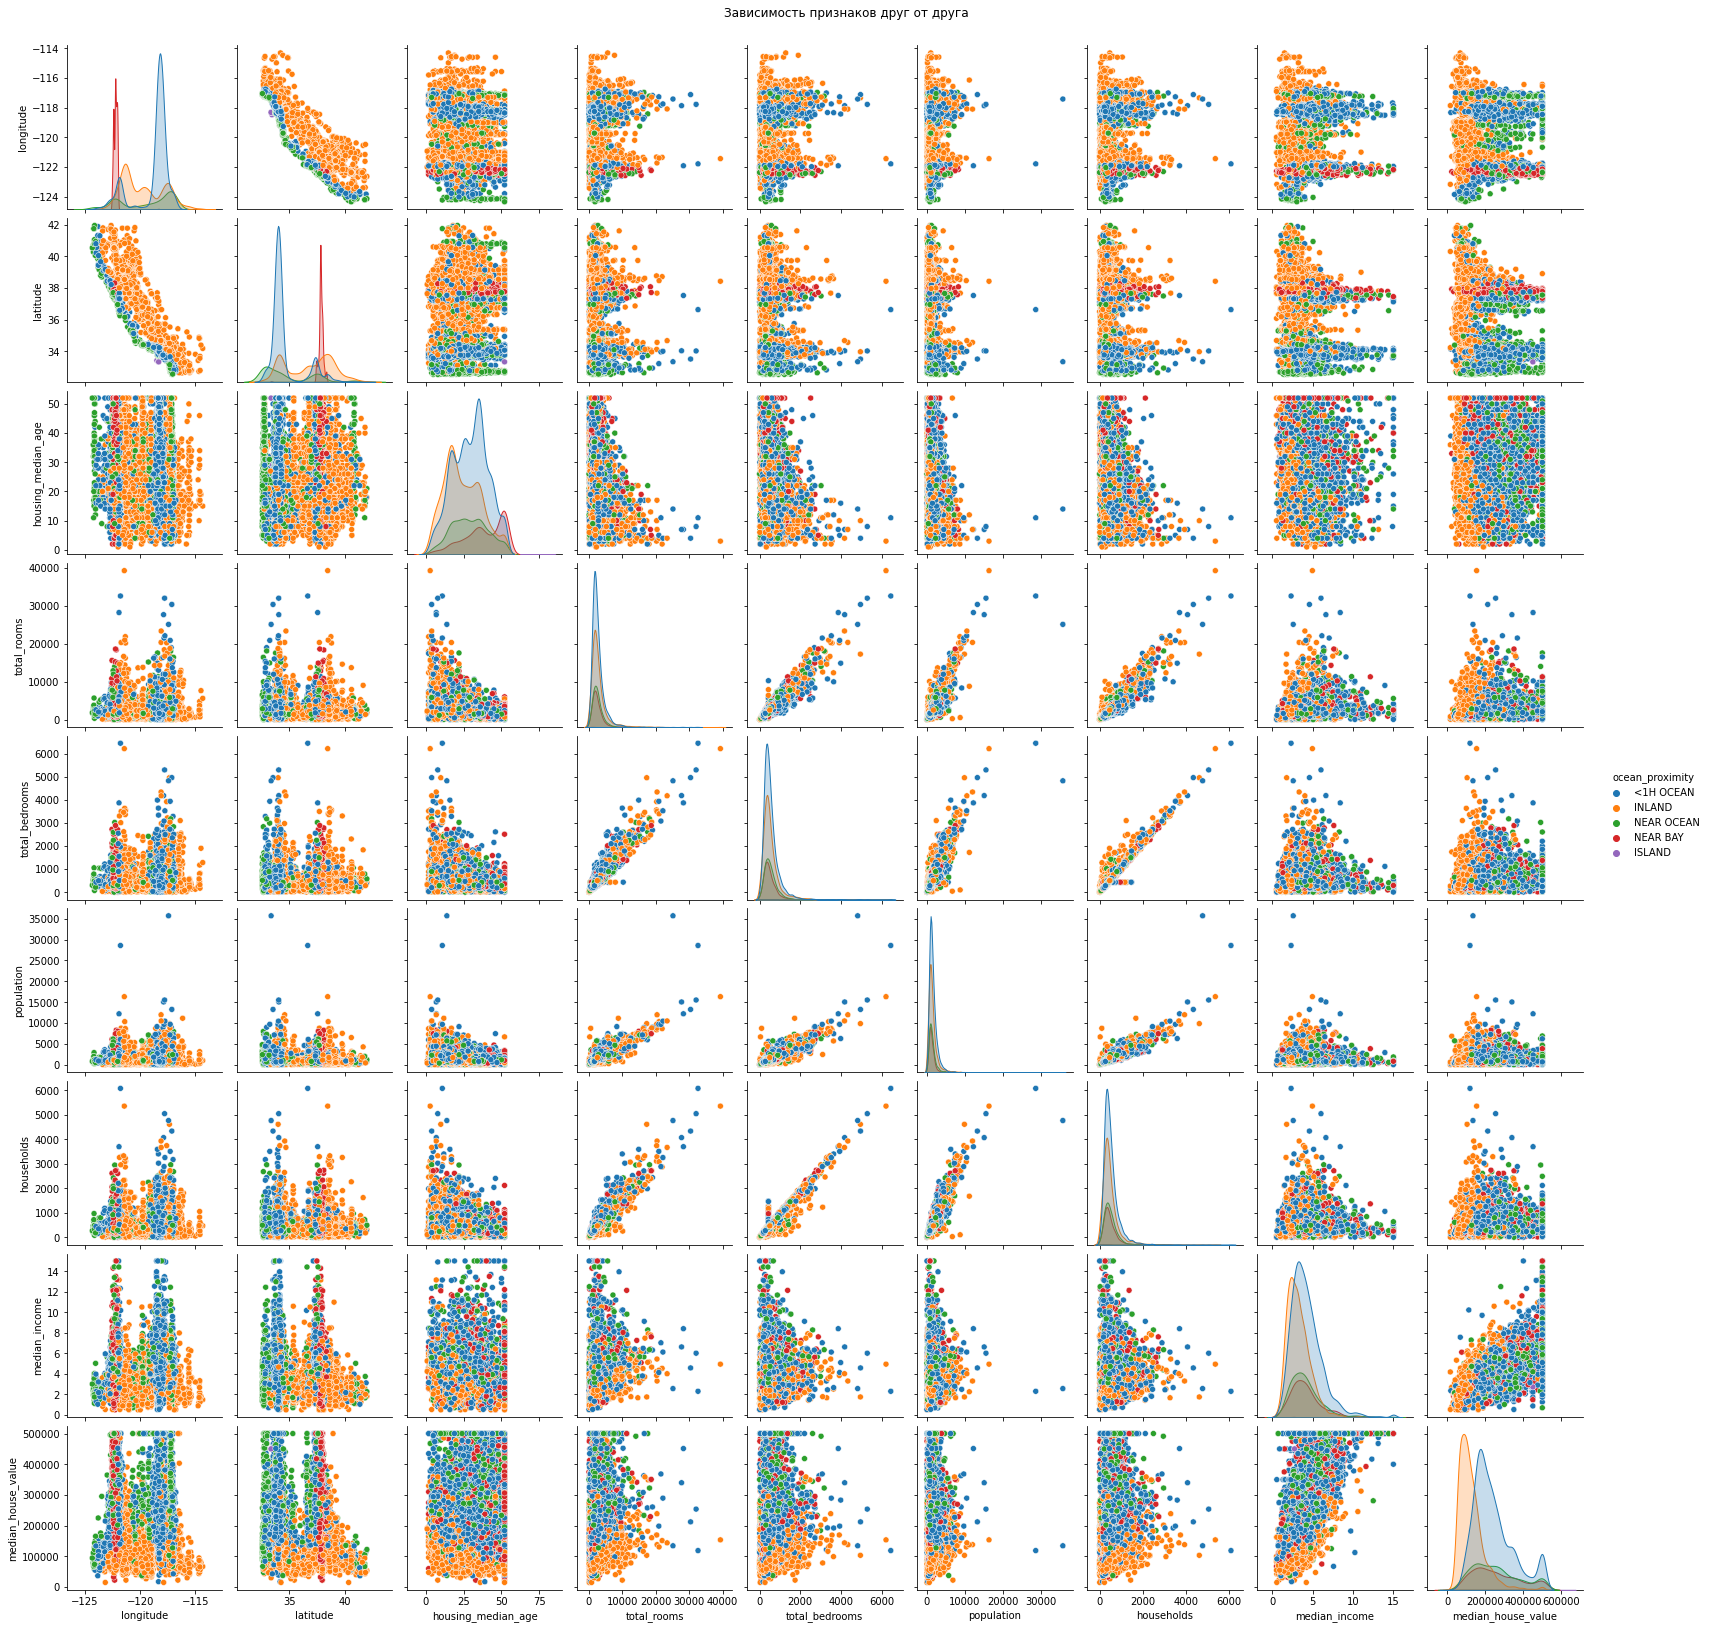

In [13]:
g = sns.pairplot(data, hue='ocean_proximity');
g.fig.suptitle('Зависимость признаков друг от друга', y=1.01);

## Предобработка признаков

Запоминаем названия категориальных и числовых признаков

In [14]:
categorial_columns = ['ocean_proximity']
numerical_columns = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', \
                     'total_bedrooms', 'population', 'households', 'median_income']
target_column = 'median_house_value'

### Разделение на тренировочную и тестовую выборки

Учитывая все признаки

In [15]:
features_train_all, features_test_all = spark_df_clear.select(
    numerical_columns+categorial_columns+[target_column]
).randomSplit([0.75, 0.25], seed=RANDOM_SEED)
print(features_train_all.count(), features_test_all.count()) 

15406 5234


In [16]:
features_train_all.limit(4).toPandas()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value
0,-124.349998,40.540001,52.0,1820.0,300.0,806.0,270.0,3.0147,NEAR OCEAN,94600.0
1,-124.300003,41.799999,19.0,2672.0,552.0,1298.0,478.0,1.9797,NEAR OCEAN,85800.0
2,-124.300003,41.840000,17.0,2677.0,531.0,1244.0,456.0,3.0313,NEAR OCEAN,103600.0
3,-124.269997,40.689999,36.0,2349.0,528.0,1194.0,465.0,2.5179,NEAR OCEAN,79000.0


Учитывая только численные признаки

In [17]:
features_train_num, features_test_num = spark_df_clear.select(
    numerical_columns+[target_column]
).randomSplit([0.75, 0.25], seed=RANDOM_SEED)
print(features_train_all.count(), features_test_all.count()) 

15406 5234


In [18]:
features_train_num.limit(4).toPandas()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-124.349998,40.540001,52.0,1820.0,300.0,806.0,270.0,3.0147,94600.0
1,-124.300003,41.799999,19.0,2672.0,552.0,1298.0,478.0,1.9797,85800.0
2,-124.300003,41.840000,17.0,2677.0,531.0,1244.0,456.0,3.0313,103600.0
3,-124.269997,40.689999,36.0,2349.0,528.0,1194.0,465.0,2.5179,79000.0


### Категориальные

Создаём индексатор. Преобразуем строки в числа. Алгоритмы понимают в основном числа

In [19]:
indexer = StringIndexer(
    inputCols=categorial_columns,
    outputCols=[c+'_idx' for c in categorial_columns]
)

In [20]:
# Не тренируем на тестовой выборке (это улучшает результаты и не даёт модели "подглядывать" ответы в тесте)
indexer_model = indexer.fit(features_train_all)

# Применяем на все выборки
features_train_all = indexer_model.transform(features_train_all)
features_test_all = indexer_model.transform(features_test_all)

Создаём кодировщик. Прямым кодирование преобразуем категориальные признаки

In [21]:
encoder = OneHotEncoder(
    inputCols=[c+'_idx' for c in categorial_columns],
    outputCols=[c+'_ohe' for c in categorial_columns]
)

In [22]:
# Не тренируем на тестовой выборке (это улучшает результаты и не даёт модели "подглядывать" ответы в тесте)
encoder_model = encoder.fit(features_train_all)

# Применяем на все выборки
features_train_all = encoder_model.transform(features_train_all)
features_test_all = encoder_model.transform(features_test_all)

Создаём вектор категориальных признаков с которым умеет работать ML-алгоритм

In [23]:
categorical_assembler = VectorAssembler(
    inputCols=[c+'_ohe' for c in categorial_columns],
    outputCol='categorial_features'
)

In [24]:
features_train_all = categorical_assembler.transform(features_train_all)
features_test_all = categorical_assembler.transform(features_test_all)

### Числовые

Создаём вектор численных признаков с которым умеет работать ML-алгоритм

In [25]:
numerical_assembler = VectorAssembler(
    inputCols=numerical_columns,
    outputCol='numerical_features'
)

In [26]:
features_train_all = numerical_assembler.transform(features_train_all)
features_test_all = numerical_assembler.transform(features_test_all)
features_train_num = numerical_assembler.transform(features_train_num)
features_test_num = numerical_assembler.transform(features_test_num)

Применяем масштабирование к числовым признаком для уравнивания их важности для ML-алгоритма

In [27]:
standart_scaler = StandardScaler(
    inputCol='numerical_features',
    outputCol='numerical_features_scaled'
)

In [28]:
# Не тренируем на тестовой выборке (это улучшает результаты и не даёт модели "подглядывать" ответы в тесте)
standart_scaler_model = standart_scaler.fit(features_train_all)

# Применяем ко всем выборкам
features_train_all = standart_scaler_model.transform(features_train_all)
features_test_all = standart_scaler_model.transform(features_test_all)
features_train_num = standart_scaler_model.transform(features_train_num)
features_test_num = standart_scaler_model.transform(features_test_num)

### Объединение

Собираем финальный вектор признаков

In [29]:
final_assembler_all = VectorAssembler(
    inputCols=['categorial_features', 'numerical_features_scaled'],
    outputCol='features'
)
final_assembler_num = VectorAssembler(
    inputCols=['numerical_features_scaled'],
    outputCol='features'
)

In [30]:
features_train_all = final_assembler_all.transform(features_train_all)
features_test_all = final_assembler_all.transform(features_test_all)
features_train_num = final_assembler_num.transform(features_train_num)
features_test_num = final_assembler_num.transform(features_test_num)

Проверка

In [31]:
features_train_all.limit(4).toPandas()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value,ocean_proximity_idx,ocean_proximity_ohe,categorial_features,numerical_features,numerical_features_scaled,features
0,-124.349998,40.540001,52.0,1820.0,300.0,806.0,270.0,3.0147,NEAR OCEAN,94600.0,2.0,"(0.0, 0.0, 1.0, 0.0)","(0.0, 0.0, 1.0, 0.0)","[-124.3499984741211, 40.540000915527344, 52.0,...","[-61.982223876749416, 18.941627966518386, 4.13...","[0.0, 0.0, 1.0, 0.0, -61.982223876749416, 18.9..."
1,-124.300003,41.799999,19.0,2672.0,552.0,1298.0,478.0,1.9797,NEAR OCEAN,85800.0,2.0,"(0.0, 0.0, 1.0, 0.0)","(0.0, 0.0, 1.0, 0.0)","[-124.30000305175781, 41.79999923706055, 19.0,...","[-61.95730367168501, 19.530340815702814, 1.509...","[0.0, 0.0, 1.0, 0.0, -61.95730367168501, 19.53..."
2,-124.300003,41.840000,17.0,2677.0,531.0,1244.0,456.0,3.0313,NEAR OCEAN,103600.0,2.0,"(0.0, 0.0, 1.0, 0.0)","(0.0, 0.0, 1.0, 0.0)","[-124.30000305175781, 41.84000015258789, 17.0,...","[-61.95730367168501, 19.549030565163303, 1.350...","[0.0, 0.0, 1.0, 0.0, -61.95730367168501, 19.54..."
3,-124.269997,40.689999,36.0,2349.0,528.0,1194.0,465.0,2.5179,NEAR OCEAN,79000.0,2.0,"(0.0, 0.0, 1.0, 0.0)","(0.0, 0.0, 1.0, 0.0)","[-124.2699966430664, 40.689998626708984, 36.0,...","[-61.94234698520275, 19.01171185346629, 2.8597...","[0.0, 0.0, 1.0, 0.0, -61.94234698520275, 19.01..."


In [32]:
features_test_all.limit(4).toPandas()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value,ocean_proximity_idx,ocean_proximity_ohe,categorial_features,numerical_features,numerical_features_scaled,features
0,-124.230003,40.540001,52.0,2694.0,453.0,1152.0,435.0,3.0806,NEAR OCEAN,106700.0,2.0,"(0.0, 0.0, 1.0, 0.0)","(0.0, 0.0, 1.0, 0.0)","[-124.2300033569336, 40.540000915527344, 52.0,...","[-61.9224123422991, 18.941627966518386, 4.1307...","[0.0, 0.0, 1.0, 0.0, -61.9224123422991, 18.941..."
1,-124.169998,40.740002,17.0,2026.0,338.0,873.0,313.0,4.0357,NEAR OCEAN,128900.0,2.0,"(0.0, 0.0, 1.0, 0.0)","(0.0, 0.0, 1.0, 0.0)","[-124.16999816894531, 40.7400016784668, 17.0, ...","[-61.892502772204246, 19.035074931468206, 1.35...","[0.0, 0.0, 1.0, 0.0, -61.892502772204246, 19.0..."
2,-124.169998,40.750000,13.0,2171.0,339.0,951.0,353.0,4.8516,NEAR OCEAN,116100.0,2.0,"(0.0, 0.0, 1.0, 0.0)","(0.0, 0.0, 1.0, 0.0)","[-124.16999816894531, 40.75, 13.0, 2171.0, 339...","[-61.892502772204246, 19.039746477657022, 1.03...","[0.0, 0.0, 1.0, 0.0, -61.892502772204246, 19.0..."
3,-124.169998,40.790001,43.0,2285.0,479.0,1169.0,482.0,1.9688,NEAR OCEAN,70500.0,2.0,"(0.0, 0.0, 1.0, 0.0)","(0.0, 0.0, 1.0, 0.0)","[-124.16999816894531, 40.790000915527344, 43.0...","[-61.892502772204246, 19.058436227117507, 3.41...","[0.0, 0.0, 1.0, 0.0, -61.892502772204246, 19.0..."


In [33]:
features_train_num.limit(4).toPandas()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,numerical_features,numerical_features_scaled,features
0,-124.349998,40.540001,52.0,1820.0,300.0,806.0,270.0,3.0147,94600.0,"[-124.3499984741211, 40.540000915527344, 52.0,...","[-61.982223876749416, 18.941627966518386, 4.13...","[-61.982223876749416, 18.941627966518386, 4.13..."
1,-124.300003,41.799999,19.0,2672.0,552.0,1298.0,478.0,1.9797,85800.0,"[-124.30000305175781, 41.79999923706055, 19.0,...","[-61.95730367168501, 19.530340815702814, 1.509...","[-61.95730367168501, 19.530340815702814, 1.509..."
2,-124.300003,41.840000,17.0,2677.0,531.0,1244.0,456.0,3.0313,103600.0,"[-124.30000305175781, 41.84000015258789, 17.0,...","[-61.95730367168501, 19.549030565163303, 1.350...","[-61.95730367168501, 19.549030565163303, 1.350..."
3,-124.269997,40.689999,36.0,2349.0,528.0,1194.0,465.0,2.5179,79000.0,"[-124.2699966430664, 40.689998626708984, 36.0,...","[-61.94234698520275, 19.01171185346629, 2.8597...","[-61.94234698520275, 19.01171185346629, 2.8597..."


In [34]:
features_test_num.limit(4).toPandas()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,numerical_features,numerical_features_scaled,features
0,-124.230003,40.540001,52.0,2694.0,453.0,1152.0,435.0,3.0806,106700.0,"[-124.2300033569336, 40.540000915527344, 52.0,...","[-61.9224123422991, 18.941627966518386, 4.1307...","[-61.9224123422991, 18.941627966518386, 4.1307..."
1,-124.169998,40.740002,17.0,2026.0,338.0,873.0,313.0,4.0357,128900.0,"[-124.16999816894531, 40.7400016784668, 17.0, ...","[-61.892502772204246, 19.035074931468206, 1.35...","[-61.892502772204246, 19.035074931468206, 1.35..."
2,-124.169998,40.750000,13.0,2171.0,339.0,951.0,353.0,4.8516,116100.0,"[-124.16999816894531, 40.75, 13.0, 2171.0, 339...","[-61.892502772204246, 19.039746477657022, 1.03...","[-61.892502772204246, 19.039746477657022, 1.03..."
3,-124.169998,40.790001,43.0,2285.0,479.0,1169.0,482.0,1.9688,70500.0,"[-124.16999816894531, 40.790000915527344, 43.0...","[-61.892502772204246, 19.058436227117507, 3.41...","[-61.892502772204246, 19.058436227117507, 3.41..."


## Обучение моделей

По всем признакам

In [35]:
linear_regression_all = LinearRegression(labelCol=target_column, featuresCol='features')

In [36]:
linear_model_all = linear_regression_all.fit(features_train_all)

23/02/25 20:38:40 WARN Instrumentation: [6b4b6c48] regParam is zero, which might cause numerical instability and overfitting.
23/02/25 20:38:41 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/02/25 20:38:41 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
23/02/25 20:38:41 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
23/02/25 20:38:41 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


Только по числовым признакам

In [37]:
linear_regression_num = LinearRegression(labelCol=target_column, featuresCol='numerical_features_scaled')

In [38]:
linear_model_num = linear_regression_num.fit(features_train_num)

23/02/25 20:38:43 WARN Instrumentation: [5d16f94c] regParam is zero, which might cause numerical instability and overfitting.


## Получение предсказаний

In [39]:
predictions_all = linear_model_all.transform(features_test_all)

In [40]:
predictions_all.select('median_house_value', 'prediction').show()

+------------------+------------------+
|median_house_value|        prediction|
+------------------+------------------+
|          106700.0| 216109.5134034427|
|          128900.0| 206526.5605447851|
|          116100.0|232557.72837473126|
|           70500.0| 163047.5453382451|
|           85600.0|187411.58313013008|
|           75500.0| 137483.5984788756|
|           79600.0| 160398.9449580144|
|           92800.0|208497.45604300732|
|           94800.0|218566.88889044896|
|           97300.0| 167799.3721337393|
|           82100.0|158737.48521425063|
|          126900.0|157482.81511819223|
|          119400.0|166515.64310683636|
|           71300.0|169209.03935978236|
|           75600.0|149163.88357665902|
|           98800.0|176880.52915172372|
|           92600.0|  151359.756817895|
|          152700.0|141352.70814776327|
|          106300.0| 175798.2554678847|
|          150000.0|158197.17372106062|
+------------------+------------------+
only showing top 20 rows



In [41]:
predictions_num = linear_model_num.transform(features_test_num)

In [42]:
predictions_num.select('median_house_value', 'prediction').show()

+------------------+------------------+
|median_house_value|        prediction|
+------------------+------------------+
|          106700.0|189461.69211055664|
|          128900.0| 173866.5036953115|
|          116100.0|199938.81503098598|
|           70500.0|130505.23772951262|
|           85600.0|155132.76248209784|
|           75500.0| 99707.47936877515|
|           79600.0|130460.25088828104|
|           92800.0| 175632.9078794266|
|           94800.0|197706.46613954613|
|           97300.0|141539.27777728532|
|           82100.0|122494.20694108587|
|          126900.0|119612.94865562255|
|          119400.0|126518.55860102642|
|           71300.0|144721.90613109386|
|           75600.0|116589.25128219929|
|           98800.0|145131.07321619987|
|           92600.0|123092.66675941786|
|          152700.0| 93241.40445751837|
|          106300.0|140895.10859173676|
|          150000.0|147348.50770175736|
+------------------+------------------+
only showing top 20 rows



## Cравнение моделей

In [43]:
evaluator_rmse = RegressionEvaluator(
    labelCol='median_house_value',
    predictionCol='prediction',
    metricName='rmse'
)

In [44]:
evaluator_mae = RegressionEvaluator(
    labelCol='median_house_value',
    predictionCol='prediction',
    metricName='mae'
)

In [45]:
evaluator_r2 = RegressionEvaluator(
    labelCol='median_house_value',
    predictionCol='prediction',
    metricName='r2'
)

In [46]:
rmse_all = evaluator_rmse.evaluate(predictions_all)
rmse_all

67169.17150207597

In [47]:
rmse_num = evaluator_rmse.evaluate(predictions_num)
rmse_num

68223.14237920252

In [48]:
mae_all = evaluator_mae.evaluate(predictions_all)
mae_all

48994.43839401639

In [49]:
mae_num = evaluator_mae.evaluate(predictions_num)
mae_num

50194.99597948272

In [50]:
r2_all = evaluator_r2.evaluate(predictions_all)
r2_all

0.6638049305976133

In [51]:
r2_num = evaluator_r2.evaluate(predictions_num)
r2_num

0.6531714858674356

## Вывод

Интерпретация метрик
- $RMSE$ — чем меньше тем лучше
- $MAE$ — чем меньше тем лучше
- $R^2$ — от $0$ до $1$, чем больше тем лучше

In [52]:
pd.DataFrame({'RMSE': [rmse_all, rmse_num], 'MAE': [mae_all, mae_num], 'R2': [r2_all, r2_num]},
             index=['все признаки', 'только числовые признаки']).style.set_caption('Сравнение моделей')

,RMSE,MAE,R2
все признаки,67169.171502,48994.438394,0.663805
только числовые признаки,68223.142379,50194.995979,0.653171


**Модель содержащая категориальные и числовые признаки вместе, показала лучшее качество, чем только числовые**

## Остановка Spark-сессии

In [53]:
spark.stop()